In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums

In [42]:
'''
Read data from excels
1. Data from group A and B, 2023
2. Data from group A and B, 2022 (old data)
'''
types = {'ExperimentA': str, 'ExperimentB': str}
E1_2023 = pd.read_excel("Raw Data/E1_ Understanding Threats 2023_February 9, 2023.xlsx", skiprows=[1], dtype=types)
# E1_2023 = pd.read_excel("../Raw Data/E1_ Understanding Threats 2023_February 9, 2023.xlsx", usecols=range(11,40), skiprows=[1])
# E1_2022 = pd.read_excel("../Raw Data/E1_2022_Cleaned_Understanding+Threats_Raw_Data - Cleaned.xlsx", header=1)
# E1_training = pd.read_excel("../Raw Data/E1_ Training 2023_February.xlsx", header=1, usecols=range(10,21))

In [43]:
'''
Dictionary {choice: T/F}
Then add choices column to dataframe
'''
answer_map = {'EXPLOIT-REMOTE-REPO': True,
              'LEAKED-CONFIG-FILE': True,
              'STOLEN-AUTH-INFO': True,
              'DOS-SERVER': True,
              'MALICIOUS-CODE-GITHUB':True,
              'ELEVATION-PRIVILEDGED-ACCESS': True,
              'DOS-REMOTE-REPO': False,
              'DISCLOSE-THIRD-PARTY': False,
              'ELEVATION-PRIVILEDGED-REPO': False,
              'ELEVATION-PRIVILEDGED-CODE': False,
              'EXPLOIT-HTTP-PROTOCOL': False}


for key in answer_map.keys():
    E1_2023.loc[:, key] = 0

In [44]:
'''
Get the matrix
We don't use funcions to handle strings, like splict, but I think it is more efficient
'''

for i in range(E1_2023.shape[0]):
    for key in answer_map.keys():
        is_choosen = (key in str(E1_2023.loc[i, 'ExperimentA'])) or (key in str(E1_2023.loc[i, 'ExperimentB']))
        if answer_map[key] and is_choosen:
            E1_2023.loc[i, key] = 1
            continue
        if not answer_map[key] and is_choosen:
            E1_2023.loc[i, key] = -1


# store data to new excel file
# E1_2023.to_excel('nb.xlsx')
# E1_2023.shape[0]

In [45]:
"""
Checked result: correct

Calculate the confusion matrix for each student in the DataFrame
:DataFrame containing 11 columns of student answers
:correct_answers: Dictionary of the correct answers
:column_names: List of column names of the options
:return: DataFrame containing the confusion matrix for each student
"""
def calculate_confusion_matrix(df, correct_answers, column_names):
    confusion_matrix = pd.DataFrame(columns=['TP', 'FN', 'FP', 'TN'])

    # Loop through each row in the DataFrame and calculate the confusion matrix
    for i, row in df.iterrows():
        # Initialize the confusion matrix values to 0
        tp, fn, fp, tn = 0, 0, 0, 0

        # Loop through each column and update the confusion matrix values
        for column in column_names:
            answer = row[column]
            correct_answer = correct_answers[column]
            # all cases
            if answer == 1:
                tp +=  1
            elif answer == -1:
                fp += 1
            else:
                if correct_answer:
                    fn += 1
                else:
                    tn += 1

        # Add the confusion matrix values to the DataFrame
        confusion_matrix.loc[i] = [tp, fn, fp, tn]

    return confusion_matrix

In [46]:
'''
A simpler approach can be used, but for the sake of standardisation, the following version is provided here
'''
def add_performance_metrics(df):
    # Be carefull the order
    tp = df.iloc[:, 0]
    fn = df.iloc[:, 1]
    fp = df.iloc[:, 2]
    tn = df.iloc[:, 3]

    # operations of pd.Series
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # add columns
    df["Recall"] = recall
    df["Precision"] = precision
    df["Accuracy"] = accuracy

    return df

In [47]:
'''
add the confusion matrix and performance metrics at the end of original matrix
Grouping
'''
confusion_matrix = calculate_confusion_matrix(E1_2023, answer_map, answer_map.keys())
performance_metrics = add_performance_metrics(confusion_matrix)

E1_2023 = pd.concat([E1_2023, confusion_matrix, performance_metrics], axis=1)
E1_2023 = E1_2023.T.drop_duplicates().T # drop duplicates

# grouping
grouped = E1_2023.groupby('GroupA')
group_a = grouped.get_group('Group A')
group_b = grouped.get_group('Group B')

In [48]:
def describe_stats_by_group(df, group_col, stats_cols):

    group_df = df.groupby(group_col)
    stats_df = group_df[stats_cols].agg([np.mean, np.median, np.std])
    stats_df.columns = [f"{col}_{stat}" for col, stat in stats_df.columns]
    # for col, stat in stats_df.columns:
    #     print(f'{col}_{stat}')
    # delete the same coloums
    return stats_df.T.drop_duplicates().T

stats_by_group = describe_stats_by_group(E1_2023, 'GroupA', ['Recall', 'Precision', 'Accuracy'])
stats_by_group

,Recall_mean,Recall_median,Recall_std,Precision_mean,Precision_median,Precision_std,Accuracy_mean,Accuracy_median,Accuracy_std
GroupA,,,,,,,,,
Group A,0.666667,0.666667,0.218218,0.639605,0.625000,0.160246,0.604651,0.636364,0.146967
Group B,0.713178,0.666667,0.203558,0.656373,0.666667,0.155651,0.638478,0.636364,0.181264


In [49]:
group_a_performance_matrix = E1_2023.loc[E1_2023['GroupA']=='Group A', ['Recall', 'Precision', 'Accuracy']]
group_b_performance_matrix = E1_2023.loc[E1_2023['GroupA']=='Group B', ['Recall', 'Precision', 'Accuracy']]

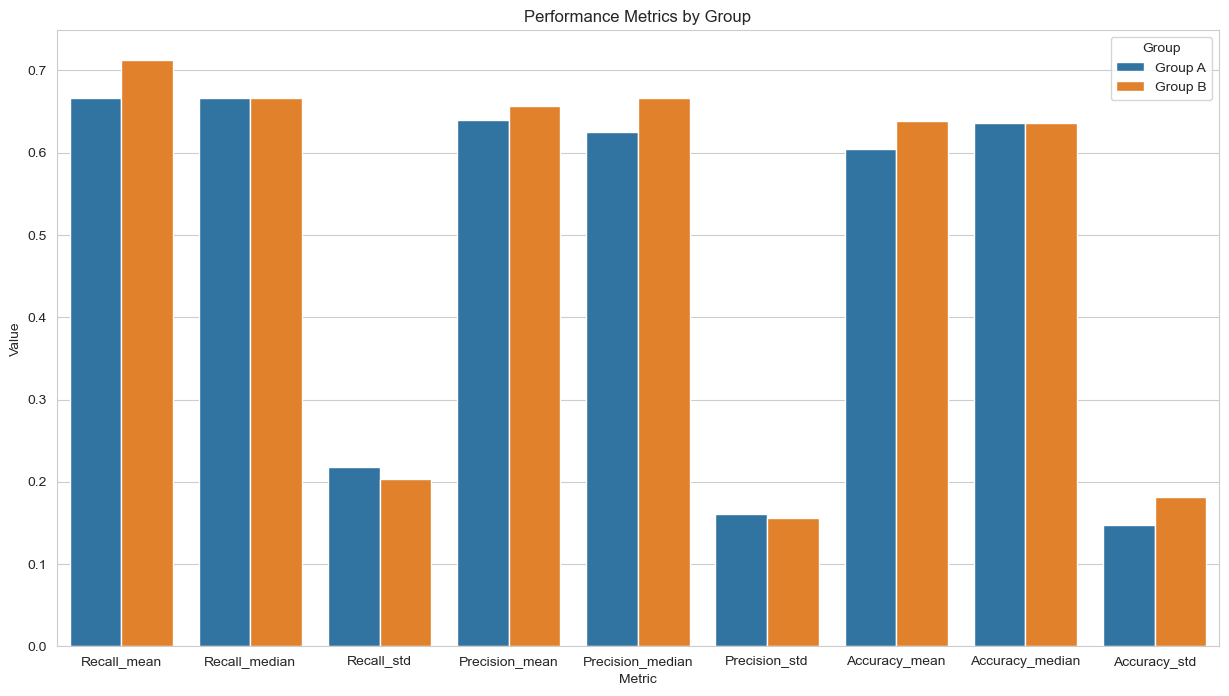

In [50]:
df = stats_by_group
cols_to_plot = stats_by_group.columns

# 将数据集转换为长格式stats_by_group
df_plot = df[cols_to_plot].stack().reset_index()
df_plot.columns = ['Group', 'Metric', 'Value']

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='Metric', y='Value', hue='Group', data=df_plot, ax=ax)

ax.legend(title='Group')
ax.set_title('Performance Metrics by Group')

# plt.xticks(rotation=45)
plt.show()


[]

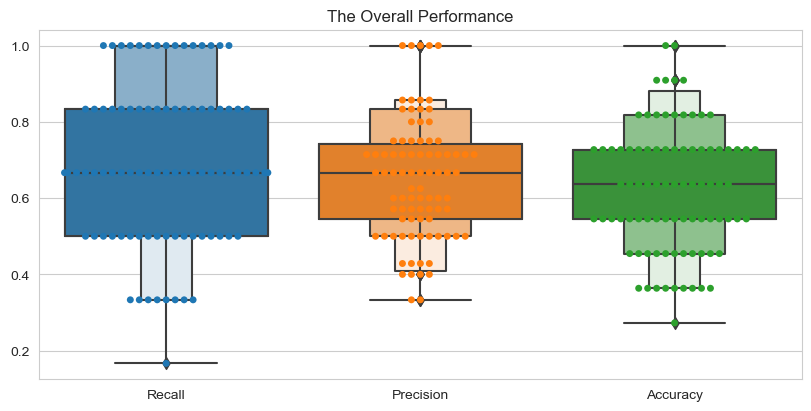

In [51]:
# learnt from https://www.cnblogs.com/chenhuabin/p/15925939.html

fig, ax =plt.subplots(constrained_layout=True, figsize=(8, 4))

sns.boxenplot(data=performance_metrics.iloc[:,4:])
sns.boxplot(data=performance_metrics.iloc[:,4:])

sns.swarmplot(data=performance_metrics.iloc[:,4:])

plt.title('The Overall Performance')
plt.plot()

[]

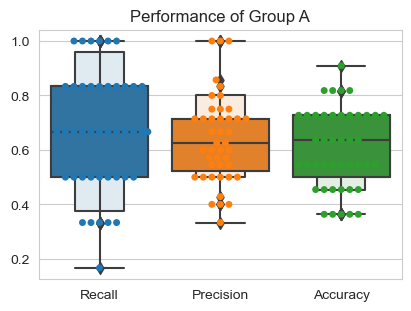

In [52]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(4, 3))
sns.boxenplot(data=group_a_performance_matrix)
sns.boxplot(data=group_a_performance_matrix)

sns.swarmplot(data=group_a_performance_matrix)

plt.title("Performance of Group A")
plt.plot()

[]

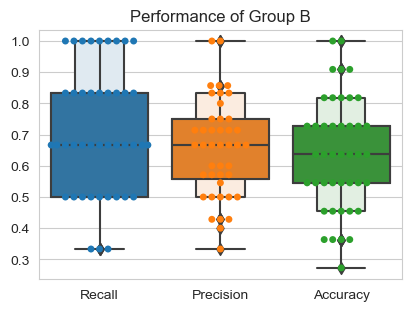

In [53]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(4, 3))
sns.boxenplot(data=group_b_performance_matrix)
sns.boxplot(data=group_b_performance_matrix)

sns.swarmplot(data=group_b_performance_matrix)

plt.title("Performance of Group B")
plt.plot()

In [54]:
recall_a_b = pd.DataFrame(
    {'recall_a': group_a_performance_matrix['Recall'], 
    'recall_b': group_b_performance_matrix['Recall']}
)
precision_a_b = pd.DataFrame(
    {'precision_a': group_a_performance_matrix['Precision'], 
    'precision_b': group_b_performance_matrix['Precision']}
)
accuracy_a_b = pd.DataFrame(
    {'accuracy_a': group_a_performance_matrix['Accuracy'], 
    'accuracy_b': group_b_performance_matrix['Accuracy']}
)

[]

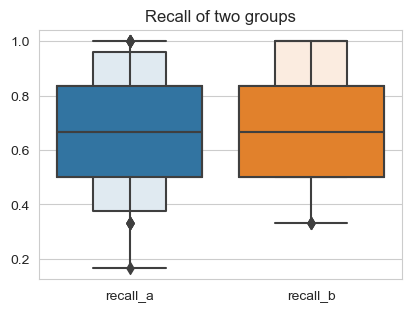

In [55]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 3))
sns.boxenplot(data=recall_a_b)
sns.boxplot(data=recall_a_b)
plt.title('Recall of two groups')
plt.plot()

[]

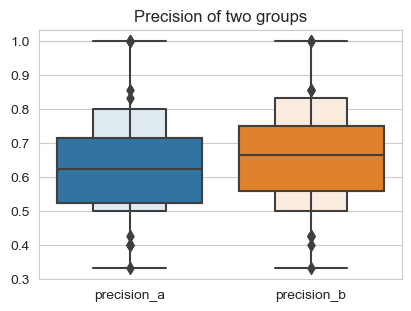

In [56]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(4, 3))
sns.boxenplot(data=precision_a_b)
sns.boxplot(data=precision_a_b)
plt.title('Precision of two groups')
plt.plot()

[]

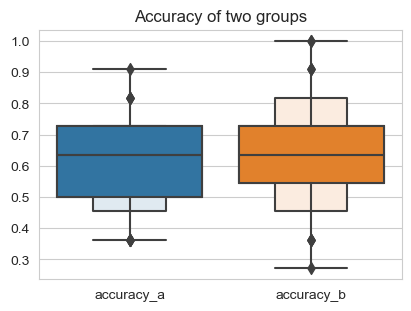

In [57]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(4, 3))
# sns.violinplot(data=precision_a_b)
sns.boxenplot(data=accuracy_a_b)
sns.boxplot(data=accuracy_a_b)

plt.title('Accuracy of two groups')
plt.plot()

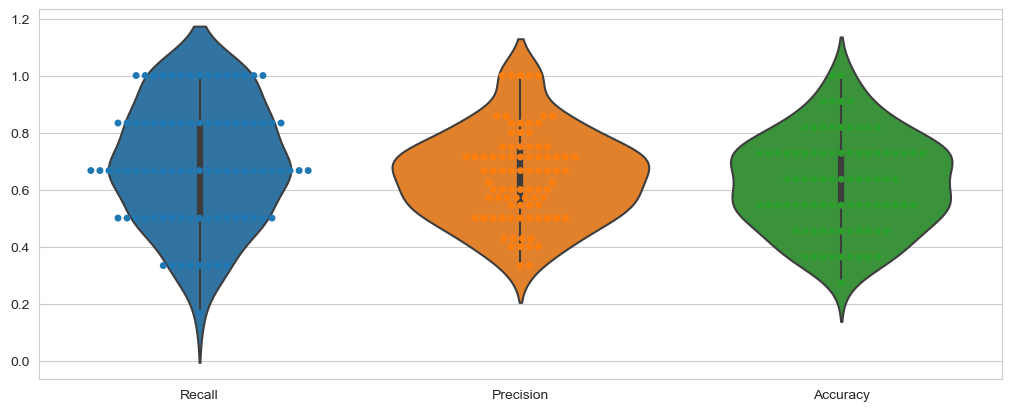

In [58]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(10, 4))
pic3 = sns.violinplot(data=performance_metrics.iloc[:,4:])
pic2 = sns.swarmplot(data=performance_metrics.iloc[:,4:])

/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

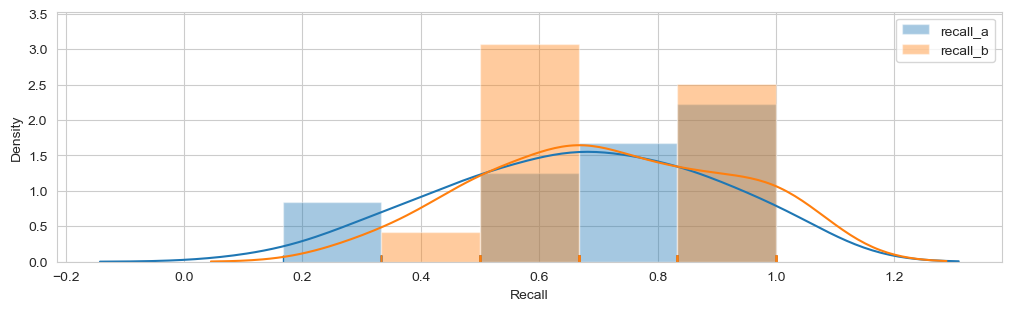

/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

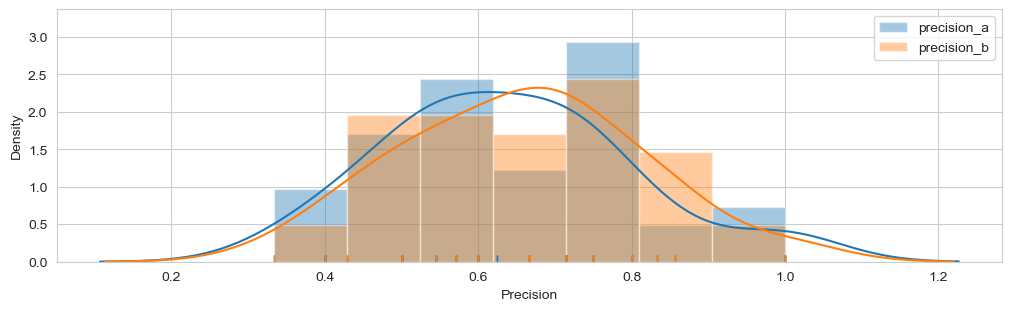

/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

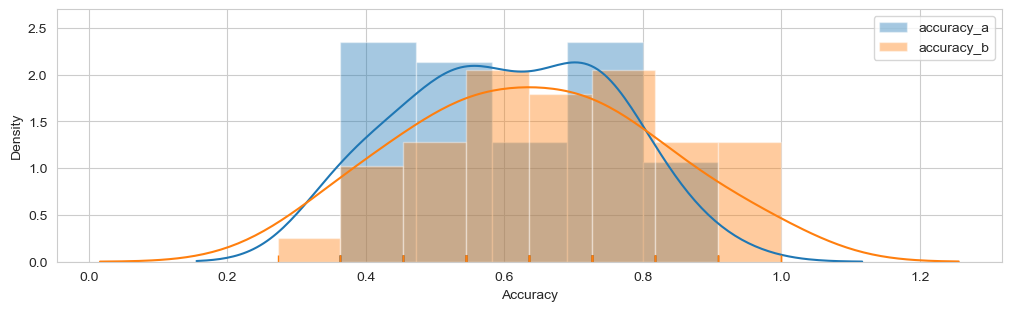

In [59]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(10, 3))
sns.distplot(group_a_performance_matrix['Recall'], rug=True, label='recall_a')
sns.distplot(group_b_performance_matrix['Recall'], rug=True, label='recall_b')
plt.legend()
plt.show()
fig, ax =plt.subplots(constrained_layout=True, figsize=(10, 3))
sns.distplot(group_a_performance_matrix['Precision'], rug=True, label='precision_a')
sns.distplot(group_b_performance_matrix['Precision'], rug=True, label='precision_b')
plt.legend()
plt.show()
fig, ax =plt.subplots(constrained_layout=True, figsize=(10, 3))
sns.distplot(group_a_performance_matrix['Accuracy'], rug=True, label='accuracy_a')
sns.distplot(group_b_performance_matrix['Accuracy'], rug=True, label='accuracy_b')
plt.legend()
plt.show()

# sns.clustermap(, rug=True, label='accuracy_a')
# plt.legend()
# plt.show()

In [76]:
# sns.clustermap(performance_metrics.iloc['Recall', 'Precision', 'Accuracy'])
# performance_metrics.iloc[:,4:]
# performance_metrics
subset = E1_2023.loc[E1_2023['GroupA'] == 'Group A', ['Recall', 'Precision']]
# print(performance_metrics.iloc[:,4:])

# sns.clustermap(subset)
# m1 = E1_2023.loc[E1_2023['GroupA'] == 'Group A', E1_2023.columns[-4:]]
# subset
# print(performance_metrics['Recall', 'Precision'])
performance_metrics.loc[,['Recall', 'Precision']]
# sns.clustermap()

KeyError: ('Recall', 'Precision')

      Recall  Precision  Accuracy
0   1.000000   0.545455  0.545455
1   0.666667   0.500000  0.454545
2   0.500000   0.428571  0.363636
3   0.333333   0.400000  0.363636
4   0.333333   0.500000  0.454545
..       ...        ...       ...
81  0.333333   0.500000  0.454545
82  0.666667   0.666667  0.636364
83  0.833333   0.833333  0.818182
84  0.666667   0.666667  0.636364
85  0.500000   0.428571  0.363636

[86 rows x 3 columns]
      Recall Precision  Accuracy
1   0.666667       0.5  0.454545
3   0.333333       0.4  0.363636
4   0.333333       0.5  0.454545
5        0.5      0.75  0.636364
6   0.833333  0.714286  0.727273
7   0.666667       1.0  0.818182
13       0.5       0.5  0.454545
17  0.833333  0.714286  0.727273
18  0.666667  0.571429  0.545455
20  0.666667  0.571429  0.545455
22       1.0  0.545455  0.545455
23  0.666667  0.571429  0.545455
28       1.0  0.545455  0.545455
29  0.666667       1.0  0.818182
32       0.5       0.6  0.545455
33  0.833333  0.714286  0.727273
34  0.83

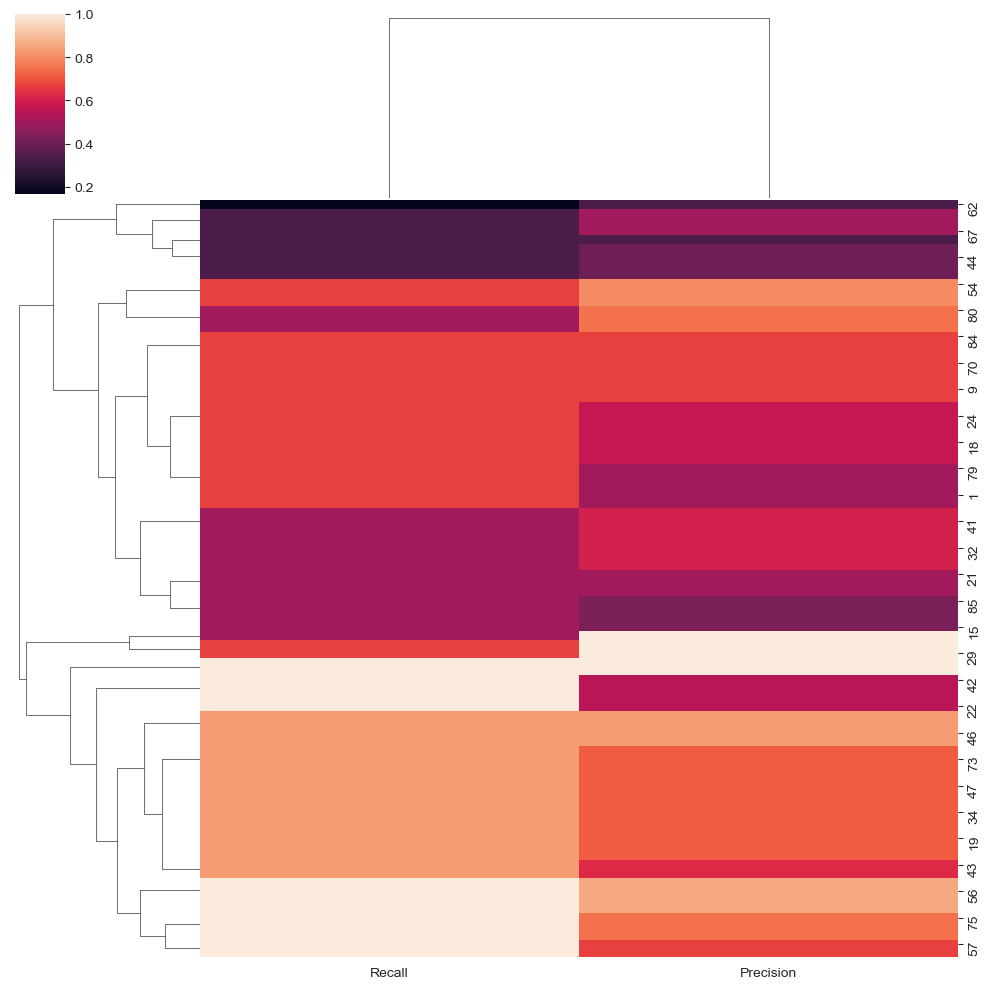

In [85]:
subset = E1_2023.loc[E1_2023['GroupA'] == 'Group A', ['Recall', 'Precision', 'Accuracy']]
print(performance_metrics.iloc[:,4:])
print(subset)
sns.clustermap(performance_metrics.iloc[:,4:6])

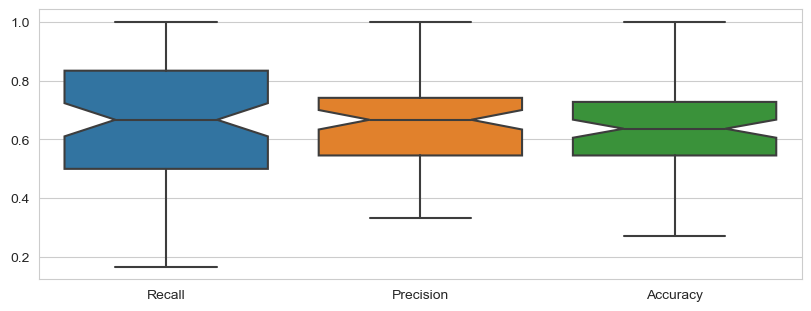

In [61]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(8, 3))
pic1 = sns.boxplot(data=performance_metrics.iloc[:,4:], notch=True)

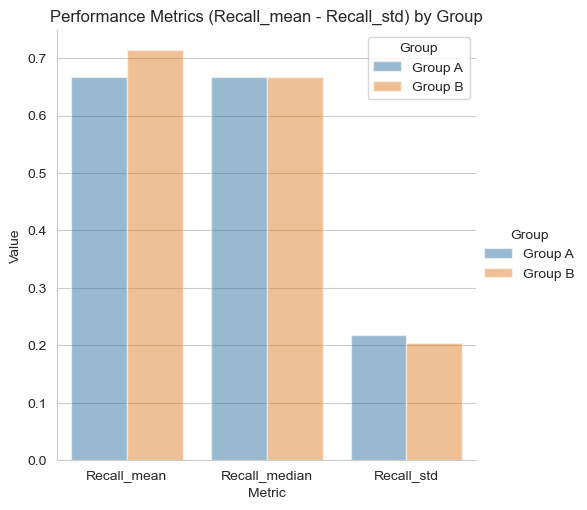

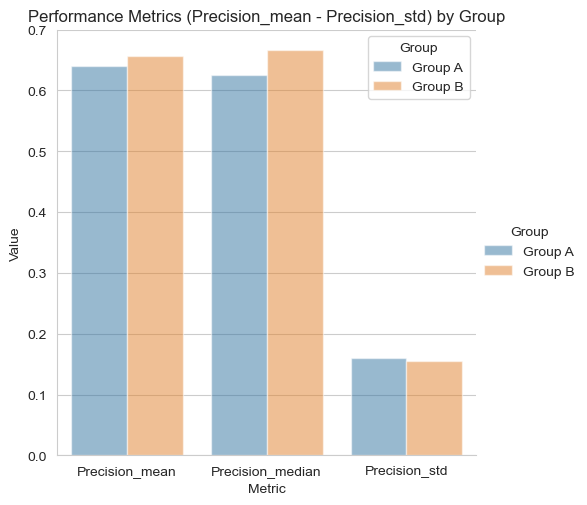

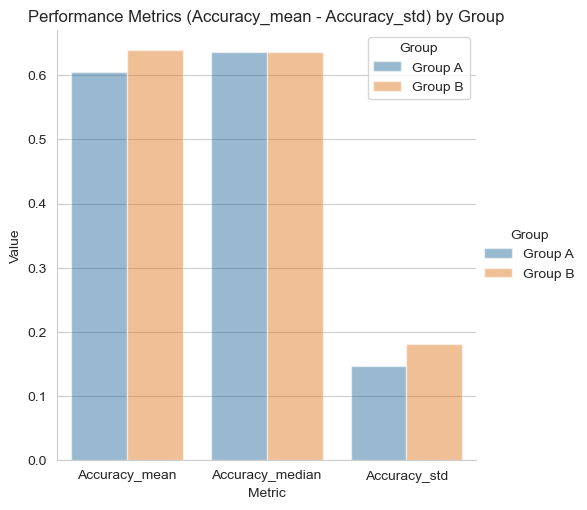

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# 调用 describe_stats_by_group 函数生成 DataFrame
df = stats_by_group

cols_to_plot = stats_by_group.columns

# each figure has 3 columns
for i in range(0, len(cols_to_plot), 3):
    cols_subset = cols_to_plot[i:i+3]
    df_subset = df[cols_subset].stack().reset_index()
    df_subset.columns = ['Group', 'Metric', 'Value']

    sns.set_style("whitegrid")
    sns.catplot(x='Metric', y='Value', hue='Group', data=df_subset, kind='bar', alpha=0.5)

    plt.legend(title='Group')
    plt.title(f'Performance Metrics ({cols_subset[0]} - {cols_subset[-1]}) by Group')
    plt.show()


In [63]:
# 需要注意的是，由于Ranksum Statistics是一种非参数检验方法，它并不要求数据服从特定的分布。但是，它对样本大小和样本中位数差异有一定的敏感度。如果样本大小较小，可能会导致统计显著性的误判，需要谨慎使用。
statistic, p_value = ranksums(group_a['Recall'], group_b['Recall'])


In [64]:
'''
ranksums检验
'''
from scipy.stats import ranksums

# recall_a = np.array(group_a['Recall'].mean())
# recall_b = np.array(group_b['Recall'].mean())

# precision_a = np.array(group_a['Precision'].mean())
# precision_b = np.array(group_b['Precision'].mean())

# accuracy_a = np.array(group_a['Accuracy'].mean())
# accuracy_b = np.array(group_b['Accuracy'].mean())

recall_stat, recall_p = ranksums(group_a['Recall'], group_b['Recall'])
precision_stat, precision_p = ranksums(group_a['Precision'], group_b['Precision'])
accuracy_stat, accuracy_p = ranksums(group_a['Accuracy'], group_b['Accuracy'])

print(f'Recall: statistic = {recall_stat:.2f}, p-value = {recall_p:.4f}')
print(f'Precision: statistic = {precision_stat:.2f}, p-value = {precision_p:.4f}')
print(f'Accuracy: statistic = {accuracy_stat:.2f}, p-value = {accuracy_p:.4f}')


alpha = 0.05
if recall_p < alpha:
    print("There is a significant difference in Recall between group A and group B")
else:
    print("There is no significant difference in Recall between group A and group B")

if precision_p < alpha:
    print("There is a significant difference in Precision between group A and group B")
else:
    print("There is no significant difference in Precision between group A and group B")

if accuracy_p < alpha:
    print("There is a significant difference in Accuracy between group A and group B")
else:
    print("There is no significant difference in Accuracy between group A and group B")


Recall: statistic = -0.88, p-value = 0.3807
Precision: statistic = -0.60, p-value = 0.5483
Accuracy: statistic = -0.82, p-value = 0.4119
There is no significant difference in Recall between group A and group B
There is no significant difference in Precision between group A and group B
There is no significant difference in Accuracy between group A and group B


In [65]:
from scipy.stats import ttest_ind
# 对比 Recall
t_statistic, t_pvalue = ttest_ind(pd.to_numeric(group_a['Recall'], errors='coerce'), 
                                   pd.to_numeric(group_b['Recall'], errors='coerce'))
print(f"t-statistic for Recall: {t_statistic:.4f}, p-value for Recall: {t_pvalue:.4f}")

if t_pvalue < alpha:
    print("There is a significant difference in Recall between group A and group B using t-test")
else:
    print("There is no significant difference in Recall between group A and group B using t-test")

# 对比 Precision
t_statistic, t_pvalue = ttest_ind(pd.to_numeric(group_a['Precision'], errors='coerce'), 
                                   pd.to_numeric(group_b['Precision'], errors='coerce'))
print(f"t-statistic for Precision: {t_statistic:.4f}, p-value for Precision: {t_pvalue:.4f}")

if t_pvalue < alpha:
    print("There is a significant difference in Precision between group A and group B using t-test")
else:
    print("There is no significant difference in Precision between group A and group B using t-test")

# 对比 Accuracy
t_statistic, t_pvalue = ttest_ind(pd.to_numeric(group_a['Accuracy'], errors='coerce'), 
                                   pd.to_numeric(group_b['Accuracy'], errors='coerce'))
print(f"t-statistic for Accuracy: {t_statistic:.4f}, p-value for Accuracy: {t_pvalue:.4f}")

if t_pvalue < alpha:
    print("There is a significant difference in Accuracy between group A and group B using t-test")
else:
    print("There is no significant difference in Accuracy between group A and group B using t-test")


t-statistic for Recall: -1.0220, p-value for Recall: 0.3097
There is no significant difference in Recall between group A and group B using t-test
t-statistic for Precision: -0.4922, p-value for Precision: 0.6239
There is no significant difference in Precision between group A and group B using t-test
t-statistic for Accuracy: -0.9505, p-value for Accuracy: 0.3446
There is no significant difference in Accuracy between group A and group B using t-test


/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/young/miniforge3/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

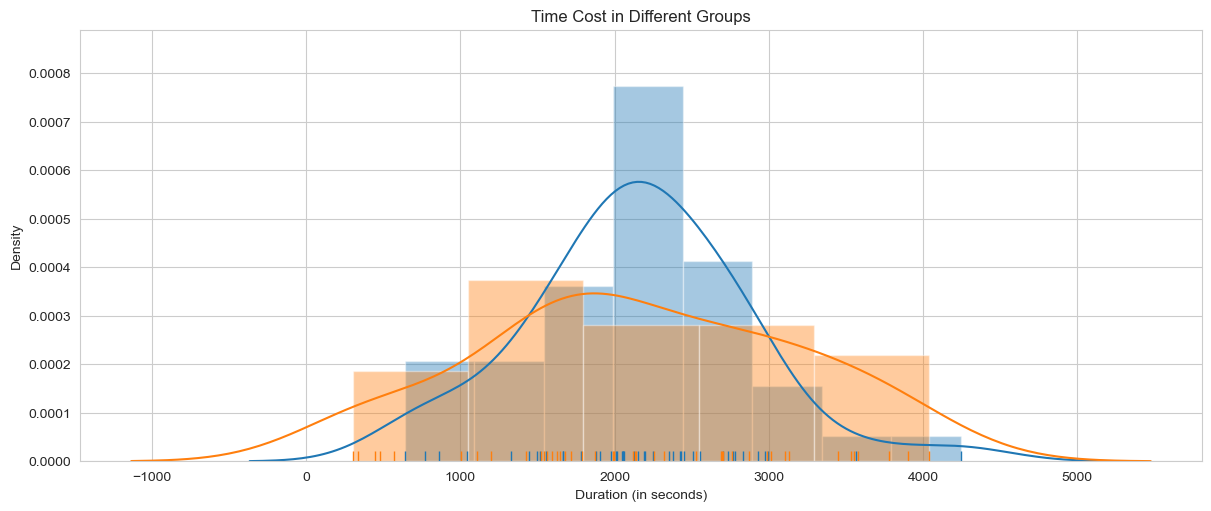

In [66]:
fig, ax =plt.subplots(constrained_layout=True, figsize=(12, 5))
sns.distplot(group_a['Duration (in seconds)'], rug=True, label='accuracy_a')
sns.distplot(group_b['Duration (in seconds)'], rug=True, label='accuracy_b')
plt.title('Time Cost in Different Groups')
plt.show()